In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
import re
import warnings
import itertools
warnings.simplefilter(action='ignore', category=FutureWarning)
from tensorflow.keras import Input, Model
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv1D
from tensorflow.keras.losses import KLDivergence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import SGD, Adam
from sklearn.metrics import mean_absolute_error, explained_variance_score, mean_squared_error, make_scorer
from tensorflow.keras.constraints import non_neg
warnings.resetwarnings()

# CNN COVID-19 case number forecasting.

Note that I've still been tinkering with the CNN post-report and so the reported results are different than the results contained here. 

# Function Declarations

In [2]:

#################  Helper functions for debugging, mainly #################
def country_slice(data, locations):
    if type(locations)==str:
        return data[data.location==locations]
    else:
        return data[data.location.isin(locations)]
    
def time_slice(data, start, end, indexer='time_index'):
    if start < 0 and end < 0:
        if start == -1:
            start = data.loc[:, indexer].max()
        else:
            start = data.loc[:, indexer].max()+start
        if end == -1:
            end = data.loc[:, indexer].max()
        else:
            end = data.loc[:, indexer].max()+end
    return data[(data.loc[:, indexer] >= start) & (data.loc[:, indexer] <= end)]

def per_country_plot(data, feature, legend=True):
    data.set_index(['time_index', 'location']).loc[:, feature].unstack().plot(legend=legend)
    return None

def per_time_plot(data, feature, legend=True):
    data.set_index(['location','time_index']).loc[:, feature].unstack().plot(legend=legend)
    return None

def country_groupby(df):
    return [df[df.location==country].index for country in df.location.unique()]

def country_search(df, country):
    return df[df.location==country].index

def column_search(df, name, return_style='loc', threshold='contains'):
    if threshold=='contains':
        func = df.columns.str.contains
    else:
        func = df.columns.str.match
        
    if return_style == 'loc':
        return df.columns[func(name)]
    elif return_style== 'iloc':
        return np.where(func(name))[0]
    else:
        return None

def residual_plot(y_test, y_predict, title='', ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    ax.scatter(y_test, y_test-y_predict.ravel(), s=5)
    ax.set_ylabel('Residual')
    ax.set_xlabel('True value')
    ax.grid(True)
    return None

def create_Xy(model_data, target_data, time_index, start_date, frame_size, n_days_into_future, n_countries):
    for max_date_in_window in range(start_date, time_index.max() - n_days_into_future + 2):
        # Take all model_data with date proxy less than numerical value, leading_window_date_not_included
        frame_data = model_data[(time_index <= max_date_in_window-1) & 
                                (time_index >= max_date_in_window-frame_size)]
        # Reshape the array such that each element along axis=0 is a time series of all feature model_data of a specific country.
        reshaped_frame_data = frame_data.values.reshape(n_countries, frame_size, -1)

        # *********************** WARNING: pad_sequences converts to integers by default *********************
        resized_frame_data = pad_sequences(reshaped_frame_data, maxlen=frame_size, dtype=np.float64)
        frame_data_4D = resized_frame_data[np.newaxis, :, :, :]
        if max_date_in_window == start_date:
            print('Starting with frame ranging time_index values:', max_date_in_window-frame_size, max_date_in_window - 1)
            X = frame_data_4D.copy()
        else:
            X = np.concatenate((X, frame_data_4D),axis=0)
    print('Ending with frame ranging time_index values:', max_date_in_window-frame_size, max_date_in_window - 1)
    y = target_data.values.reshape(-1, time_index.nunique()).transpose()[-X.shape[0]:,:]
    return X, y

def split_Xy(X, y, frame_size, n_validation_frames, n_test_frames, train_test_only=False, model_type='cnn'):
    """ Split into training, validation and test data.
    """
    # the indices for the train-validate-test splits for when the predictors are put in a 2-d format.
    train_indices = list(range(n_countries*0, n_countries*(len(X)-(n_validation_frames+n_test_frames))))
    validate_indices = list(range(n_countries*(len(X)-(n_validation_frames+n_test_frames)), n_countries*(len(X)-n_test_frames)))
    test_indices = list(range(n_countries*(len(X)-n_test_frames), n_countries*len(X)))
    indices = (train_indices, validate_indices, test_indices)

    # Note that the last frame (date_range) that exists in X has already been determined by the choice of the number
    # of steps to predict in the future, this is only slicing the frames. 
    if train_test_only:
        X_train= X[:-n_test_frames,:,:,:]
        y_train =  y[:-n_test_frames,:]
        X_test = X[-n_test_frames:, :, :, :] 
        y_test = y[-n_test_frames:, :]
        splits =  (X_train, y_train, X_test, y_test)
    else:
        y_train =  y[:-(n_validation_frames+n_test_frames),:]
        y_validate = y[-(n_validation_frames+n_test_frames):-n_test_frames, :]
        X_train= X[:-(n_validation_frames+n_test_frames),:,:,:]
        y_train =  y[:-(n_validation_frames+n_test_frames),:]
        X_validate = X[-(n_validation_frames+n_test_frames):-n_test_frames, :, :, :]
        y_validate = y[-(n_validation_frames+n_test_frames):-n_test_frames, :]
        X_test = X[-n_test_frames:, :, :, :] 
        y_test = y[-n_test_frames:, :]
        splits =  (X_train, y_train, X_validate, y_validate,
                   X_test, y_test)

    return splits, indices


def model_analysis(y_true, y_naive, y_predict, n_countries, title='',suptitle='', 
                   figname=None, scale=None, s=None, model_params=None):
    print('There were {} negative predictions'.format(len(y_predict[y_predict<0])))
    #     y_predict[y_predict<0]=0
    # compute scores 
    mse_naive = mean_squared_error(y_true.ravel(), y_naive.ravel())
    mse_predict = mean_squared_error(y_true.ravel(), y_predict)
    r2_naive = explained_variance_score(y_true.ravel(), y_naive.ravel())
    r2_predict = explained_variance_score(y_true.ravel(), y_predict)

    print('{}-step MSE [Naive, {}] = [{},{}]'.format(
    n_days_into_future,title, mse_naive, mse_predict))
    print('{}-step R^2 [Naive, {}] = [{},{}]'.format(
    n_days_into_future,title, r2_naive, r2_predict))

    fig, axes = plt.subplots(2, 2, figsize=(15,10))
    (ax1,ax2,ax3,ax4) = axes.flatten()
    if scale == 'log':
        ymax = np.max([np.log(1+y_true).max(), np.log(1+y_predict).max()])
        ax1.scatter(np.log(y_true+1), np.log(y_naive+1), s=s,alpha=0.7)
        ax1.plot([0, ymax], [0, ymax],color='r')
        ax2.scatter(np.log(y_true+1), np.log(y_predict+1), s=s,alpha=0.7)
        ax2.plot([0, ymax], [0, ymax],color='r')
    else:
        ymax = np.max([y_true.max(), y_predict.max()])
        ax1.scatter(y_true, y_naive, s=s)
        ax1.plot([0, ymax], [0, ymax],color='r')
        ax2.scatter(y_true, y_predict, s=s)
        ax2.plot([0, ymax], [0, ymax],color='r')
    
    ax1.text(0.0, ymax,'$MSE$ = {}'.format(np.round(mse_naive,3)),fontsize=14)
    ax1.text(0.0, 0.9*ymax,'$R^2$ = {}'.format(np.round(r2_naive,3)),fontsize=14)
    ax1.set_xlabel('True value')
    ax1.set_ylabel('Predicted value')
    ax1.set_title('Naive model')
             
    ax2.text(0.0, ymax,'$MSE$ = {}'.format(np.round(mse_predict,3)),fontsize=14)
    ax2.text(0.0, 0.9*ymax,'$R^2$ = {}'.format(np.round(r2_predict,3)),fontsize=14)
    ax2.set_xlabel('True value')
    ax2.set_ylabel('Predicted value')
    ax2.set_title(title)
    ax1.grid(True)
    ax2.grid(True)
    plt.suptitle(suptitle)

    
    xrange = range(len(y_true))
    if scale=='log':
        residual_plot(np.log(y_true+1),np.log(y_naive+1), ax=ax3)
        residual_plot(np.log(y_true+1),np.log(y_predict+1), ax=ax4)
    else:
        residual_plot(y_true,y_naive, ax=ax3)
        residual_plot(y_true,y_predict, ax=ax4)
    ax3.set_title('')
    ax4.set_title('')
    ax3.set_ylabel('Residual')
    ax4.set_ylabel('Residual')
    ax3.grid(True)
    ax4.grid(True)
    
    if figname is not None:
        plt.savefig(figname, bbox_inches='tight')
        
    if model_params is not None:
        param_labels = ['epochs = ', 'batch_size = ', 'filter_1 = ', 'filter_2 = ', 
                        'kernel_size_1 = ', 'kernel_size_2 = ', 'first_dense_layer_output_dimension = ']
        label_value_pairs = [param_labels[i] + str(model_params[i]) for i in range(len(model_params))]
        plt.text(0.0, 1.15, ', '.join(label_value_pairs), transform=ax1.transAxes)
    plt.show()
    return None

def normalize_Xy(splits, feature_range=(0., 1.0), normalization_method='minmax',
                        train_test_only=False, feature_indices=None):
    """ Split into training, validation and test data.
    
    
    Notes
    -----
    Normalize with respect to some arbitrary absolute max, just choose 2*absolute max of training set. 
    The function is so long because the different shapes of the different ps
    """
    
    min_, max_ = feature_range
    (X_train, y_train, X_validate, y_validate, X_test, y_test) = splits
    feature_minima = X_train[:,:,:,:].min((0,1,2))[np.newaxis,np.newaxis,np.newaxis,:]
    feature_maxima = 2*X_train[:,:,:,:].max((0,1,2))[np.newaxis,np.newaxis,np.newaxis,:]
    feature_denominator = feature_maxima-feature_minima
    # get the shape of each split's array, so that array arithmetic can be done. 
    train_tile_shape = np.array(np.array(X_train.shape)/np.array(feature_maxima.shape),int)
    validate_tile_shape = np.array(np.array(X_validate.shape)/np.array(feature_maxima.shape),int)
    test_tile_shape = np.array(np.array(X_test.shape)/np.array(feature_maxima.shape),int)

    # using X - X_min / (X_max-X_min). Form denominator
    train_denominator = np.tile(feature_denominator, train_tile_shape)
    validate_denominator = np.tile(feature_denominator, validate_tile_shape)
    test_denominator = np.tile(feature_denominator, test_tile_shape)
    
    # and then the minima.
    train_minima = np.tile(feature_minima,train_tile_shape)
    validate_minima = np.tile(feature_minima,validate_tile_shape)
    test_minima = np.tile(feature_minima,test_tile_shape)
    
    # factor of 1/max_ accounts for absolute maximum that is outside of the data (i.e. potential future values). 
    X_train_scaled = (max_-min_)*(X_train - train_minima)/train_denominator
    X_validate_scaled = (max_-min_)*(X_validate - validate_minima)/validate_denominator
    X_test_scaled = (max_-min_)*(X_test - test_minima)/test_denominator

    
    scaled_splits = (X_train_scaled, y_train, X_validate_scaled, y_validate, X_test_scaled, y_test) 
    scaling_arrays =  (feature_maxima, feature_minima, feature_denominator)

    return scaled_splits, scaling_arrays

def concatenate_4d_into_3d(splits, train_test_only=False):
    
    if train_test_only:
        (X_train, y_train, X_test, y_test) = splits
        X_train = np.concatenate(X_train, axis=0)
        y_train = np.concatenate(y_train, axis=0)
        X_test = np.concatenate(X_test, axis=0)
        y_test = np.concatenate(y_test, axis=0)
        concat_splits = (X_train, y_train, X_test, y_test) 
    else:
        (X_train, y_train, X_validate, y_validate, X_test, y_test) = splits
        X_train = np.concatenate(X_train, axis=0)
        y_train = np.concatenate(y_train, axis=0)
        X_validate = np.concatenate(X_validate, axis=0)
        y_validate = np.concatenate(y_validate, axis=0)
        X_test = np.concatenate(X_test, axis=0)
        y_test = np.concatenate(y_test, axis=0)
        concat_splits = (X_train, y_train, X_validate, y_validate, X_test, y_test) 
    return concat_splits

# Data

The main format (shape) of the data and how it is being sliced and then reshaped is described in the notebook ```COVID19_model_prototypes.ipynb``` and so I will avoid a redundant discussion here. 

In regards to the feature data being considered, I am using the time dependent variables pertaining directly to COVID-19, such as new cases, new deaths, etc. as well as time dependent variables which quantify different governments' reactions to the pandemic; most notably is the usage of the oxford's "stringency index" which scores each goverments reaction with a number from 0 to 100.

I am in fact not using the data on the number of tests, however, because the feature lacks a consistent set of units. In the regression this is counteracted upon by using one-hot encoding to categorize the units but instead of stratifying the new tests variable by units, I elect to simply drop the testing data, which may or may not be an unwise choice. 

In [3]:
# Import cleaned data produced by other notebook. 
data = pd.read_csv('cnn_data.csv',index_col=0)

There is data on 132 countries, and for 161 different days. There is not case information for all countries for all dates, this may be a source of error and one potential correction is to remove all "frames" which contain 0 information on the pandemic. 

In [4]:
print('There are {} different countries included in the data'.format(data.location.nunique()))
print('The time series span {} different days'.format(data.time_index.nunique()))

There are 146 different countries included in the data
The time series span 183 different days


The full intersection of countries in fact included more information, but the countries with populations less than 1 million people were pruned from the dataset, in order to remove any chance of undue influence from very small states such as the Vatican or San Marino, for example. 

In [5]:
# not enough countries have new_recovered_weighted values.
data = data.drop(columns=['date'])

In [6]:
data = pd.read_csv('regression_data.csv', index_col=0)
tmp =pd.read_csv('regression_data_full.csv', index_col=0)
data = pd.concat((data,tmp.loc[:, column_search(tmp,'government_response')]),axis=1)
data = data.drop(columns=['date'])
data = data.drop(columns=column_search(data,'test'))
data = data.drop(columns=column_search(data,'deaths'))
data = data.drop(columns=column_search(data,'recovered'))
# data = data.drop(columns=column_search(data,'log'))
data = data.drop(columns=column_search(data,'std'))

The main purpose of this notebook is to tune the hyperparameters and architecture of a simple one dimensional convolutional neural network such that it is able to make accurate predictions of the number of new cases. In pursuit of this goal, I elect to utilize the keras API for the deep learning implementation. The details or philosophy on how the model is constructed is also detailed in the model prototypes notebook, this notebook is simply devoted to tuning the model parameters; the architecture could also be played with (and has been) but I will leave any dramatically different architectures to different notebooks. The current architecture in this notebook represents the best (using the performance from the prototyping stage as a metric). Other inclusions which were previously tested were: more activation layers, pooling layers, dropout layers, non negative kernel constraints (the predicted value should be non-negative, there is a constraint for this). The architecture that is fixed in this notebook consists of two convolutional layers followed by two fully connected layers. In the first convolutional layer, the number of filters is chosen to be much larger than the filters in the second convolutional layer (but is also tuned). Likewise, the output of the first fully connected layer is much larger than the second (which has only 1 output in this setup). To ensure that all future tests are comparable, I always start with the same model coefficients by initializing the kernels of each layer of the network. This introduces even more parameters, using a normal distribution to initialize, such as the mean and standard deviation. This is not an issue however as in the final model these kernel initializers will be unincluded. The data is split such that the final holdout set contains a single day's information, the validation set contains 1 week or 7 days of information and the remainder is in the training set.

As a reminder, the data format as well as the features being included are both described in the model prototyping notebook. The most obvious parameters with which to tune the model are the number of training epochs, the batch size of the training, the number of filters in each convolutional layer, the size of the convolutional kernel (i.e. convolutional window) and finally the number of outputs in the first dense layer. The number of convolutional filters are chosen such that the ratio is always the same between the first and second layer. Something to keep in mind as well is that the data I am training with contains only 20000 samples, and so the number of parameters should reflect this fact, by not being too numerous. 

The following values will be used for tuning purposes. 

    epochs = [50, 100, 200]
    batch_size = [64, 256, 1024]
    filter1 = [16,32,64]
    filter2 = [2,4,8]
    kernel1_size = [4,6,8]
    kernel2_size = [4,6,8]
    
I elect to constrain the output of the first dense layer to be the same as the number of inputs to the first dense layer, which is in turn the number of outputs of the second convolutional layer. This dimension depends on the kernel size as well as filter number in said convolutional layers.

Create a 5-d tensor for convolution and FC layer parameters using itertools.
The layers of the CNN will remain the same throughout testing for now. That is, 

    1. Conv1D(f1, k1)
    2. Conv1D(f2, k2)
    3. Flatten
    4. Dense(d)


I don't know enough yet, but my intuition tells me that the overall trend (macroscopic picture)
is much more important to capture than microscopic. 
   
    f1 : number of filters,  first convolutional layer
    k1 : kernel size, first convolutional layer
    f1 : number of filters,  second convolutional layer
    k1 : kernel size, second convolutional layer
    d : number of nodes in hidden fully connected layer
    

from https://papers.nips.cc/paper/7320-how-many-samples-are-needed-to-estimate-a-convolutional-neural-network.pdf
To achieve error $\epsilon$ with filter number $m$ the number of samples needed is $\mathcal{O}(m/\epsilon^2)$
Let $\epsilon = 0.1$, then $100m$ = samples or $m = samples/100$. The number of samples is
It seems that included information from the too distant past actually makes the model worse. 

# Main differences from prototyping stage.

The data being used, and the parameters being tuned; it was the architecture that was mainly tested previously in the
prototyping notebook.

In [7]:
# data = data[data.time_index>=40]
# model_data = data.copy().iloc[:, 3:]
modeling_features = ['new_cases_per_million', 'government_response_index', 'log_new_cases_per_million']
model_data = data.copy().loc[:, modeling_features]
new_cases_index = column_search(model_data,'new_cases_per_million', threshold='match', return_style='iloc')[0]
n_countries = data.location.nunique()
target_data = data.new_cases_per_million
time_index = data.time_index

frame_size = 28
start_date = frame_size + data.time_index.min()

n_validation_frames = 7
n_test_frames = 1
n_days_into_future = 1

Create, split, and scale the data into tensors which will abide by keras conventions (after collapsing the first axis, at least)

In [8]:
X, y = create_Xy(model_data, target_data, time_index, start_date, frame_size, n_days_into_future, n_countries)
splits, indices = split_Xy(X, y, frame_size, n_validation_frames, n_test_frames)

scaled_splits, scaling_arrays =  normalize_Xy(splits, feature_range=(0,1.0), 
                                                                  normalization_method='minmax',
                                                                  train_test_only=False,
                                                                  feature_indices=None)
# if need to supply folds for sklearn CV regression functions.
(X_cnn_train, y_cnn_train, X_cnn_validate, y_cnn_validate, X_cnn_test, y_cnn_test) = scaled_splits
(train_indices, validate_indices, test_indices) = indices

Starting with frame ranging time_index values: 0 27
Ending with frame ranging time_index values: 154 181


Visualize the split into training, validation, testing sets using a single time series. The data passed to the CNN utilizes frames of time, so in the visualization I am identifying each frame with its leading edge. I.e. the testing (green) set contains a single frame of 28 days of values, not a single day's worth of values as one might be lead to believe by the single green point.

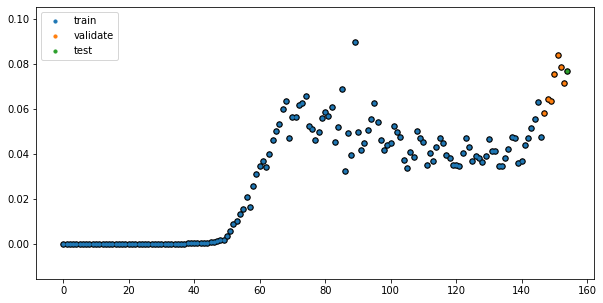

In [9]:
X_scaled_tmp = np.concatenate((X_cnn_train,X_cnn_validate,X_cnn_test), axis=0)

fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.scatter(range(len(X_scaled_tmp)), X_scaled_tmp[:,np.where(data.location.unique()=='United States')[0],-1,new_cases_index], s=30,color='k')
ax.scatter(range(len(X_cnn_train)), X_cnn_train[:,np.where(data.location.unique()=='United States')[0],-1,new_cases_index], s=10, label='train')
ax.scatter(range(len(X_cnn_train), len(X_cnn_train)+len(X_cnn_validate)), X_cnn_validate[:,np.where(data.location.unique()=='United States')[0],-1,new_cases_index], s=10, label='validate')
ax.scatter(range(len(X_cnn_train)+len(X_cnn_validate), len(X)), X_cnn_test[:,np.where(data.location.unique()=='United States')[0],-1,new_cases_index], s=10, label='test')
plt.legend()
_ = plt.show()

After the data is split with respect to time, the axis corresponding to time is collapsed such that the 
"batch" (keras notation) axis now contains all frames for all countries.

In [10]:
splits_3d = concatenate_4d_into_3d(scaled_splits)
(X_cnn_train_model, y_cnn_train_model, X_cnn_validate_model,
 y_cnn_validate_model, X_cnn_test_model, y_cnn_test_model) = splits_3d

Instantiate the naive baseline values for comparison.

In [11]:
X_for_naive_slicing = np.concatenate(X.reshape(X.shape[0], X.shape[1], -1), axis=0)
n_features = X.shape[-1]
last_day_new_cases_index = np.ravel_multi_index([[frame_size-1],[new_cases_index]],(frame_size, n_features))
y_train_naive = X_for_naive_slicing[train_indices, last_day_new_cases_index].ravel()
y_validate_naive =  X_for_naive_slicing[validate_indices, last_day_new_cases_index].ravel()
y_test_naive =  X_for_naive_slicing[test_indices, last_day_new_cases_index].ravel()

Combinations of hyperparameters with which to tune the model with.

In [12]:
epochs_list = [500]
# use a larger batch size for cross validation to speed it up
batch_size_list = [1024]
filter1_list = [16]
filter2_list = [4]
kernel1_size_list = [8]
kernel2_size_list = [8]
# need to keep the number of parameters down, used to be way too many parameters. 
# With these kernel sizes, the dimension of the input to first dense layer is 56
first_dense_layer_output_dimension_list = [2, 4, 8, 16, 32, 64]

Combine the parameter lists into combinations using itertools.

In [13]:
parameter_combinations = list(itertools.product(epochs_list, batch_size_list, filter1_list,
                                                filter2_list, kernel1_size_list, kernel2_size_list,
                                                first_dense_layer_output_dimension_list))

In order to both save the results as well as ensure that the run of this notebook can be broken up into sessions, create a DataFrame which logs the scores and saves them to a .csv file. During the exploration of hyperparameters, this csv will be overwritten with the inclusion of any new scores calculated. This will allow for comparison and analysis of the hyper parameter space, as well as ensure that we do not have to fit the model 729 times per run of this notebook. The scores that are saved are the ones generated by the validation set predictions. Also included for comparison purposes are the scores resulting from the naive baseline. 

In [14]:
save_filename = 'cnn_score_logging_all_but_dense_dimension_frozen.csv'
if os.path.isfile(save_filename):
    score_logging_df = pd.read_csv(save_filename, index_col=0)
else:
    score_logging_df = pd.DataFrame(np.array(parameter_combinations), 
                                    columns=['epochs','batch_size','filter_1','filter_2','kernel_1','kernel_2','first_dense_layer_output_dimension'])
    score_logging_df.loc[:, 'mean_squared_error'] = np.nan
    score_logging_df.loc[:, 'mean_absolute_error'] = np.nan
    score_logging_df.loc[:, 'explained_variance'] = np.nan
    score_logging_df.loc[:, 'naive_mean_absolute_error'] = np.nan
    score_logging_df.loc[:, 'naive_explained_variance'] = np.nan
    score_logging_df.loc[:, 'naive_mean_squared_error'] = np.nan

## Convolutional neural network model 
<a id='model'></a>
[Return to table of contents](#toc)

I use static seeds to ensure that the cross-validation process is reproducible.

In [15]:
zero_seeds = [0,1,2]
one_seeds = [3,4,5]
two_seeds = [6,7,8]
three_seeds = [9,10,11]
zero_seeds = [0]
one_seeds = [3]
two_seeds = [6]
three_seeds = [9]


The convolution will be with respect to time, specifically the time steps within frames of time of predetermined length. The architecture of the CNN itself is two convolutional layers followed by two dense layers, ending with a ReLU activation layer. The key pieces of information to keep in mind when creating the neural network models are that I need to keep the parameter number small to account for the relatively small number of samples, to include only most important time dependent features and to make sure time ordering is respected.


In [ ]:
for i, hyper_parameters in enumerate(parameter_combinations):
    
    mse_list = []
    naive_mse_list = []
    explained_variance_list = []
    naive_explained_variance_list = []
    mae_list = []
    naive_mae_list = []
    
    (epochs, batch_size, filter1, 
     filter2, kernel1_size, kernel2_size,first_dense_layer_output_dimension) = hyper_parameters
    
    if score_logging_df.isna().loc[i,'mean_squared_error']:
        for j in range(len(zero_seeds)):
            cnn = Sequential()
            cnn.add(Conv1D(filters=int(filter1), kernel_size=int(kernel1_size),
                             padding='valid',
                             input_shape=X_cnn_train.shape[2:],
                             use_bias=False,
                            kernel_initializer=RandomNormal(seed=zero_seeds[j])
                            )
                     )
            cnn.add(Conv1D(filters=int(filter2), 
                             kernel_size=int(kernel2_size), 
                             padding='valid',
                             use_bias=False,
                            kernel_initializer=RandomNormal(seed=one_seeds[j])
                            )
                     )
            cnn.add(Flatten())
            cnn.add(Dense(first_dense_layer_output_dimension, 
                          kernel_initializer=RandomNormal(seed=two_seeds[j])
                           )
                     )
            cnn.add(Dense(1, 
                            activation='relu',
                          kernel_initializer=RandomNormal(seed=three_seeds[j])
                               ))
            cnn.compile(loss='mse', optimizer=Adam())
            history = cnn.fit(X_cnn_train_model, y_cnn_train_model, epochs=epochs, validation_data=(X_cnn_validate_model, y_cnn_validate_model), 
                      batch_size=batch_size, verbose=0)

            y_true = y_cnn_validate_model.ravel()
            y_predict = cnn.predict(X_cnn_validate_model).ravel()
            y_naive = y_validate_naive.ravel()

            # naive mse, r2, mae
            naive_mse_list.append(mean_squared_error(y_true.ravel(), y_naive.ravel()))
            naive_explained_variance_list.append(explained_variance_score(y_true.ravel(), y_naive.ravel()))
            naive_mae_list.append(mean_absolute_error(y_true.ravel(), y_naive.ravel()))

            # mse, r2, mae
            mse_list.append(mean_squared_error(y_true.ravel(), y_predict))
            explained_variance_list.append(explained_variance_score(y_true.ravel(), y_predict))
            mae_list.append(mean_absolute_error(y_true.ravel(), y_predict))

        score_logging_df.loc[i,'naive_mean_squared_error'] =  np.mean(naive_mse_list)
        score_logging_df.loc[i,'mean_squared_error']  = np.mean(mse_list)
        score_logging_df.loc[i,'naive_explained_variance']  = np.mean(naive_explained_variance_list)
        score_logging_df.loc[i,'explained_variance']  = np.mean(explained_variance_list)
        score_logging_df.loc[i,'naive_mean_absolute_error']  =np.mean(naive_mae_list)
        score_logging_df.loc[i,'mean_absolute_error']  = np.mean(mae_list)
        # every time a new score is calculated, overwrite the original file, to save space but also save progress scoring.
        score_logging_df.to_csv(save_filename)
    else:
        pass
    
    print('#',end='')
    if (i % 50 == 0) & (i>0):
          print(' {} runs completed'.format(str(i)))



Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\nn_ops.py:61: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  elif not isinstance(value, collections.Sized):


#

A quick look at the different results (mean squared error of predictions on validation set)>

In [ ]:
score_logging_df

In [ ]:
score_logging_df.mean_squared_error.apply(lambda x : np.log10(x+1)).plot(linestyle='none', marker='.', markersize=10)

Use these "best" model parameters with random kernels instead of the seeded ones.

In [ ]:
best_model_parameters = score_logging_df.loc[score_logging_df.mean_squared_error.idxmin(),:].iloc[:7]
best_model_parameters.astype(int)

The static seeds for the ultimate model.

In [ ]:
kernel5 = RandomNormal(seed=5)
kernel6 = RandomNormal(seed=6)
kernel7 = RandomNormal(seed=7)
kernel8 = RandomNormal(seed=8)

Now that parameters have been tuned, can use both the validation and training sets for training, and then predict on the final hold-out, testing set.

In [ ]:
X_final_train = np.concatenate((X_cnn_train_model, X_cnn_validate_model),axis=0)
y_final_train = np.concatenate((y_cnn_train_model, y_cnn_validate_model),axis=0)

Compile and preview the final model to ensure the parameter number isn't too large. 

In [ ]:
best_model_parameters= best_model_parameters.astype(int).values
(epochs, batch_size, filter1, 
 filter2, kernel1_size, kernel2_size,first_layer_output_dimension) = best_model_parameters
best_cnn = Sequential()
best_cnn.add(Conv1D(filters=int(filter1), kernel_size=int(kernel1_size),
                 padding='valid',
                 input_shape=X_cnn_train.shape[2:],
                 use_bias=False,
                kernel_initializer=kernel5,
                )
         )
best_cnn.add(Conv1D(filters=int(filter2), 
                 kernel_size=int(kernel2_size), 
                 padding='valid',
                 use_bias=False,
                kernel_initializer=kernel6,
                )
         )
best_cnn.add(Flatten())
best_cnn.add(Dense(first_layer_output_dimension,
                kernel_initializer=kernel7,
               )
         )
best_cnn.add(Dense(1, 
                activation='relu',  
                kernel_initializer=kernel8,
                   ))
best_cnn.compile(loss='mse', optimizer=Adam())
best_cnn.summary()

Look at the final set of weights to see if anything unusual occurred.

In [ ]:
fig, axes = plt.subplots(2,2, figsize=(5,5),sharex=True)
(ax1,ax2,ax3,ax4) = axes.flatten()
_ = ax1.hist(best_cnn.get_weights()[0].ravel())
_ = ax2.hist(best_cnn.get_weights()[1].ravel())
_ = ax3.hist(best_cnn.get_weights()[2].ravel())
_ = ax4.hist(best_cnn.get_weights()[3].ravel())
plt.show()

Train the final model.

In [ ]:
history = best_cnn.fit(X_final_train, y_final_train, epochs=epochs, validation_data=(X_cnn_test_model, y_cnn_test_model), 
          batch_size=batch_size, verbose=1)

## Analysis and conclusion
<a id='conclusion'></a>
[Return to table of contents](#toc)

To ensure that we are not overtraining the final CNN model, let's look at the plots of validation loss and training loss as a function of the number of epochs.

In [ ]:
_ = plt.plot(history.history['loss'], label='loss')
_ = plt.plot(history.history['val_loss'], label='val_loss')
_ = plt.legend()
_ = plt.show()

In [ ]:
_ = plt.plot(history.history['loss'][-25:], label='loss')
_ = plt.plot(history.history['val_loss'][-25:], label='val_loss')
_ = plt.legend()
_ = plt.show()

Overtraining would be signalled by the validation loss increasing while the training loss decreases; there does not seem to be substantial evidence for this so we can move onto the prediction results. As a final sanity check, predict the outcomes of the training data, to see whether or not the predictions perform better than the naive baseline; if not, then either something is wrong or the model is not worth pursuing.

In [ ]:
best_model_parameters

In [ ]:
y_true = y_final_train.ravel()
y_predict = best_cnn.predict(X_final_train).ravel()
y_naive = np.concatenate((y_train_naive, y_validate_naive),axis=0)
model_analysis(y_true, y_naive, y_predict, n_countries, title='CNN model',
               suptitle='Naive baseline vs. predictions of training set',
              figname='cnn_train_performance.jpg')

Next, check the efficacy of the model by predicting the validation data. Note that this is different from the "testing" set, or hold-out set, which is used for the final check of the model. 

In [ ]:
y_true = y_cnn_test_model.ravel()
y_predict = best_cnn.predict(X_cnn_test_model).ravel()
y_naive = y_test_naive
model_analysis(y_true, y_naive, y_predict, n_countries, title='CNN model',
               suptitle='Naive baseline vs. predictions of testing set',
              figname='cnn_test_performance.jpg', model_params=best_model_parameters)

# Future Work

I would like to test whether or not removing some of the less "helpful" data would train the CNN more accurately. I.e. take the subset of the data where all countries have at least a single presenting case; this can be sliced by the conditional statement "data.days_since_first_case >= 1". Alternatively, I coulud simply truncate all time series but a certain cutoff date. This would be more uniform and hopefully have the same effect. Because the number

In [ ]:
from sklearn.linear_model import Ridge

In [ ]:
r = Ridge()
_ = r.fit(score_logging_df.iloc[:,:7],score_logging_df.iloc[:,8])

In [ ]:
r.coef_

The variance of the mean squared error is larger at 50 epochs but so is the absolute minimum. This means that 50 epochs is more unreliable due to undertraining. Therefore recommend 100 epochs. 

In [ ]:
score_logging_df

In [ ]:
score_logging_df.plot.scatter(x='epochs',y='mean_squared_error')

In [ ]:
'cnn_score_logging.csv', 'cnn_score_logging_25_epochs.csv','cnn_score_logging_dense_output_dimension.csv',
'cnn_score_logging_dense_output_dimension_more_training.csv'

In [ ]:
pd.read_csv('cnn_score_logging.csv',index_col=0).groupby('epochs').mean_squared_error.min()

In [ ]:
pd.read_csv('cnn_score_logging_dense_output_dimension_more_training.csv',index_col=0)

In [ ]:
pltdat = pd.read_csv('cnn_score_logging_dense_output_dimension_more_training.csv',index_col=0)#.groupby('first_dense_layer_output_dimension').mean_squared_error.plot(legend=True)
# sns.lineplot(x='epochs', y='mean_squared_error', hue='first_dense_layer_output_dimension', data=pltdat)
sns.lineplot(x='epochs', y='mean_squared_error', hue='first_dense_layer_output_dimension', data=pltdat, legend='full')

Even though originally I thought that including too many parameters would negatively affect performance, the opposite appears to be true. Because of the large batch size it's not obvious how many epochs to train on. The higher the dimension is, the longer it would take to overtrain (at least that is my intuition). We can see when overtraining starts to occur by seeing when the validation loss (mean squared error) no longer uniformly decreases with respect to parameter dimension. 

In [ ]:
import glob

score_df = None
for x in glob.glob('cnn_score_logging*'):
    tmp = pd.read_csv(x, index_col=0)
    if score_df is None:
        score_df = tmp
    else:
        score_df = pd.concat((score_df,tmp),axis=0)
score_df = score_df.reset_index(drop=True)

In [ ]:
ncolors = score_df.first_dense_layer_output_dimension.nunique()


fig, ax = plt.subplots()
cax = score_df.plot.scatter(x='epochs', y='mean_squared_error', 
                      c='first_dense_layer_output_dimension',
                      figsize=(10,10), 
                      ax=ax,
                      cmap=plt.cm.get_cmap('viridis', ncolors))
loc,lab = plt.xticks()
_ = ax.set_xticks([int(l) for l in loc[1:]])
_ = ax.set_xticklabels([int(l) for l in loc[1:]])

Scores seem to be the best for 500 epochs, let's see the order of the first layer output dimension and take the one